**After this laboratory you should be able to**
- Explain how to train GNN's


# Prediction heads

**Node level tasks**  
We have the embeddings, we can predict using the embeddings. Just add a head that maps from the final node embedding dimension to the number of classes / regression targets.  
After that we can compute the loss between the predicted and real targets. 

**Exmaple**  
We can use a *softmax* function with the computed predictions to classify a node.


**Edge level tasks**  
Here we need to make predictions using **pairs** of node embeddings $(h_u, h_v)$. We have multiple options:
1. Concatenate embeddings + linear predictor (like in GAT)
2. Dot product between embeddings
    - $\hat{y}_{uv} = h_u^Th_v$ -- here $\hat{y}_{uv}$ is a single number => we can do a binary prediction
    - $\hat{y}^{(1)}_{uv} = h_u^TW^{(1)}h_v \ \dots \ \hat{y}^{(k)}_{uv} = h_u^TW^{(k)}h_v$ -- We can use a weight matrix $W$  / class for a k-class prediction. After that we concatenate the final results

**Graph level tasks**  
We want to predcit using all the node embeddings from a graph. Therefore, want to *aggregate* the embeddings of the nodes in some way. Again, there are multiple options. 
1. Global mean pooling -- Used when number of nodes  doesn't matter as much. 
2. Global max pooling
3. Global sum pooling -- Used when the structure of the graph matters more.

**Problem with pooling**  
Large graphs might use too much information (especially prevalent in large graphs). Solution: [Hierarchical Graph Representation Learning with
Differentiable Pooling](https://arxiv.org/pdf/1806.08804.pdf) (photo from here)

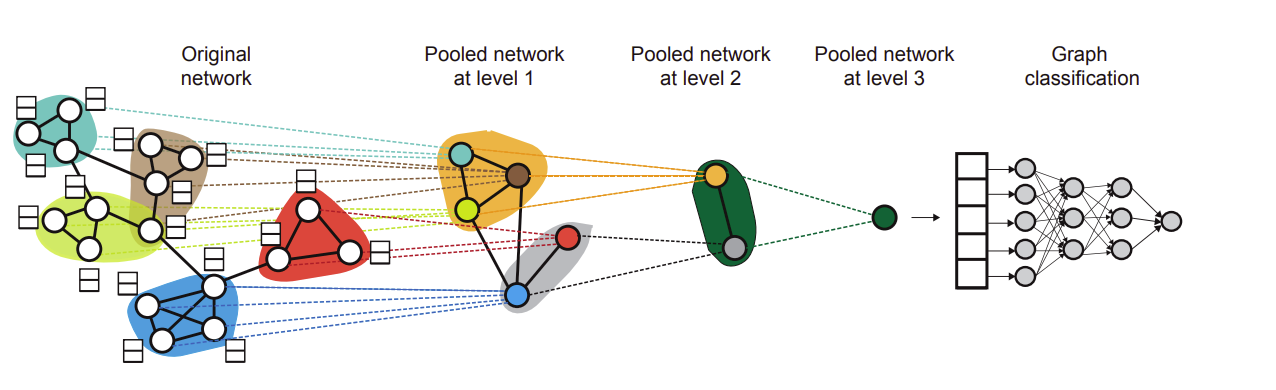

# Train splits

## Training, validation, test

We want to find a model that trains on our data and makes predictions. We want to evaluate this model too. Therefore, we willsplit our dataset into a **training, validation and testing** dataset.

**What is evaluation?**
- Looking at how the model performs based on different *metrics*
    - Ex: Accuracy, confusion matrices etc
    
**Training dataset**
- The model will be trained on this dataset. 
- We can evaluate the model on this dataset in order to see if it **learns something**

**Validation dataset**
- The model will **not** be trained on this dataset. 
- We will evaluate the model on this dataset in order to see if it **generalizes** to samples it hasn't seen before
- After evaluation we will fine tune by hand our model (change some hyperparameters)
    - Human input

**Testing dataset**
- The model will **not** be trained on this dataset. 
- We will evaluate the model on this dataset in order to see how it would perform **in the wild**. (real world)
- This is the final challenge
    - No human input

https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets

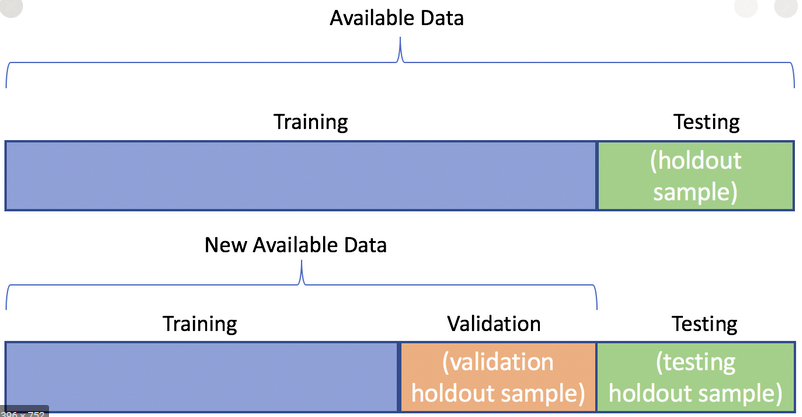

**Careful about**
- Data representativeness $\to$ the data splits should have the same proportions of classes. 
    - Ex: If trainset has 60% class 1 and 40% class 2 then the  validation set shouldn't have 20% class 1 and 80% class 2
- Time: Careful if you split by time
- Duplicate data

## K-fold

To remove the random bias from a single split we might wanna run more experiments where we shuffle the training and validation split multiple times and at the end we average the results.

*When?*
- Little data available
- $+$ Better evaluation
- $-$ Expensive

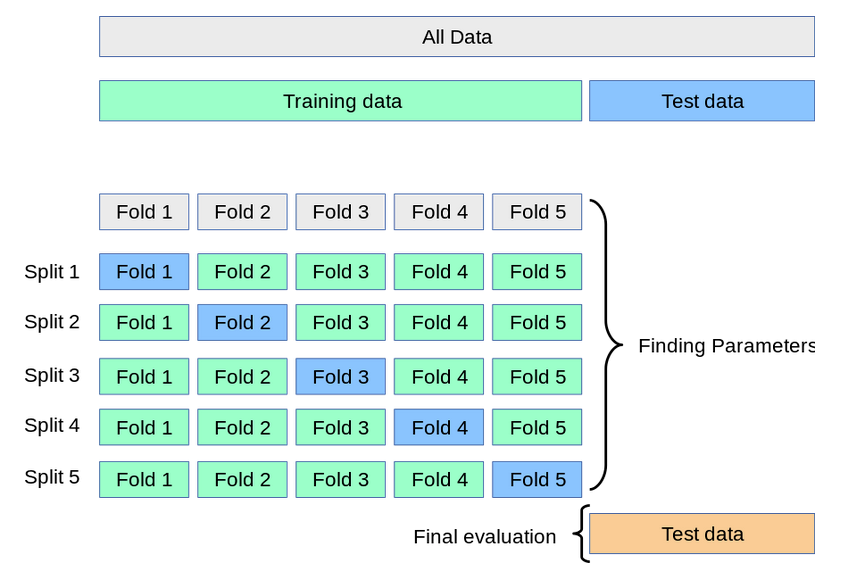

## Problems and solutions 

**Information leakage**  
In simple datasets (like images, tabular data) splitting is easy because each instance is independent from each other. In graphs this is not true because nodes are linked and when we do message aggregation we might collect data from nodes in the validation / test set which we are not supposed to. 

Example: if we compute the embedding of node 1 (train dataset) we collect information from node 5 (test dataset) => node 5 will influence the prediction on node 1

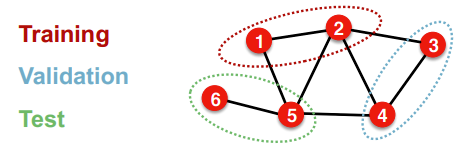


### Node classification

**Transductive setting**  
Like above, the entire graph is used in all dataset splits, we split only the labels into train, validation and test.

**Problem**
- Information leakage

**Inductive setting**  
We disconnect the graph into multiple graphs -- Train graph, validation graph, test graph. In this case there is no information leakage because we don't use information from our validation / test datasets

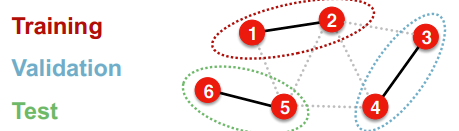

**Problem**
- We throw away edges, for small graphs this might be hurt the performance

### Graph classification

Here each graphs is independent. We split normally into training, validation and test datasets.

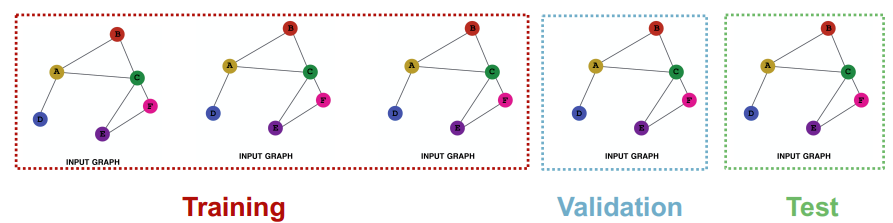

### Edge prediction

We need to create the splits on our own. We start with the graph and we have to hide some edges and try to predict if they will appear.

We have to split the graph into 2 types of edges
1. *Message passing edges* -- Used for GNN message passing
2. *Supervision edges* -- Used for training the network ( compute loss, performance etc)

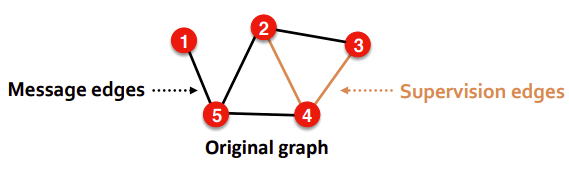


**Transductive setting**  
Take the original graph and set which edges are for messsage edges, supervision edges, validation edges and test edges.
- When training use only message edges to predict supervision edges
- When validating use message edges and supervision edges to predict  validation edges
- When testing use message edges, supervision edges and validation edges to predict test edges

*Intuition*: Graph evolving over time by adding edges

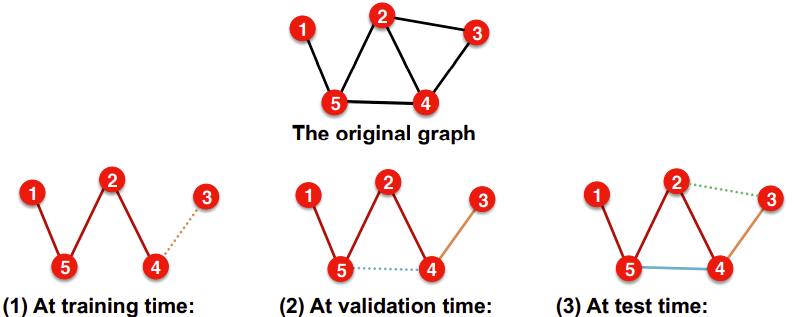


# 

- [Link split](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.RandomLinkSplit)
- [Node split](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.RandomNodeSplit)

In [1]:
import os
from copy import deepcopy

import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch_geometric.transforms as pyg_T
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import from_networkx, to_networkx

### Graph classification task

In [2]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(
    root=os.path.join("..", "data", "tmp", "enzymes"), name="ENZYMES"
)

# Transforms a torch_geometric dataset into a list of deepsnap Graphs

Extracting ../data/tmp/enzymes/ENZYMES/ENZYMES.zip
Processing...
Done!


In [3]:
idx1 = int(len(dataset) * 0.6)
idx2 = int(len(dataset) * 0.8)
perm = torch.randperm(len(dataset))

dataset_train = dataset[perm][:idx1]
dataset_val = dataset[perm][idx1:idx2]
dataset_test = dataset[perm][idx2:]

In [4]:
dataset_train, dataset_test, dataset_val

(ENZYMES(360), ENZYMES(120), ENZYMES(120))

### Node classification task

In [5]:
G = nx.karate_club_graph()
nx.set_node_attributes(
    G,
    {k: 0 if n["club"] == "Mr. Hi" else 1 for k, n in G.nodes.items()},
    name="node_label",
)

In [6]:
color_dict = {
    k: list(matplotlib.colors.BASE_COLORS.keys())[v]
    for k, v in nx.get_node_attributes(G, "node_label").items()
}

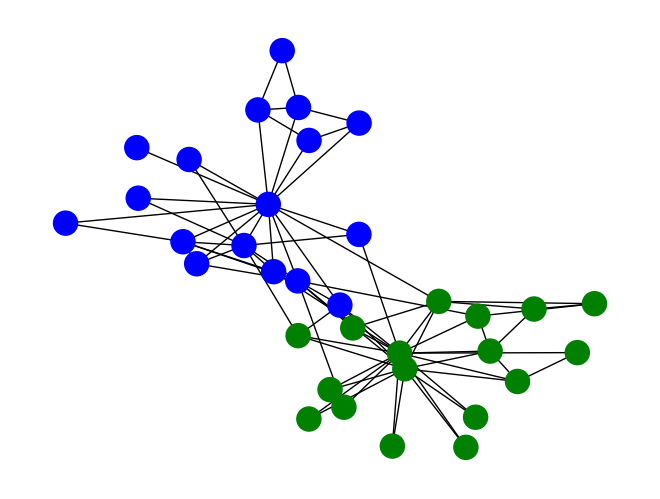

In [7]:
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos=pos, node_color=list(color_dict.values()))

In [8]:
data = from_networkx(G)
print(data)
data = pyg_T.RandomNodeSplit(
    split="train_rest", num_val=0.2, num_test=0.2, key="node_label"
)(data)
print(data)

Data(edge_index=[2, 156], club=[34], node_label=[34], weight=[156], name='Zachary's Karate Club', num_nodes=34)
Data(edge_index=[2, 156], club=[34], node_label=[34], weight=[156], name='Zachary's Karate Club', num_nodes=34, train_mask=[34], val_mask=[34], test_mask=[34])


In [9]:
print(sum(data.train_mask))
print(sum(data.val_mask))
print(sum(data.test_mask))

tensor(20)
tensor(7)
tensor(7)


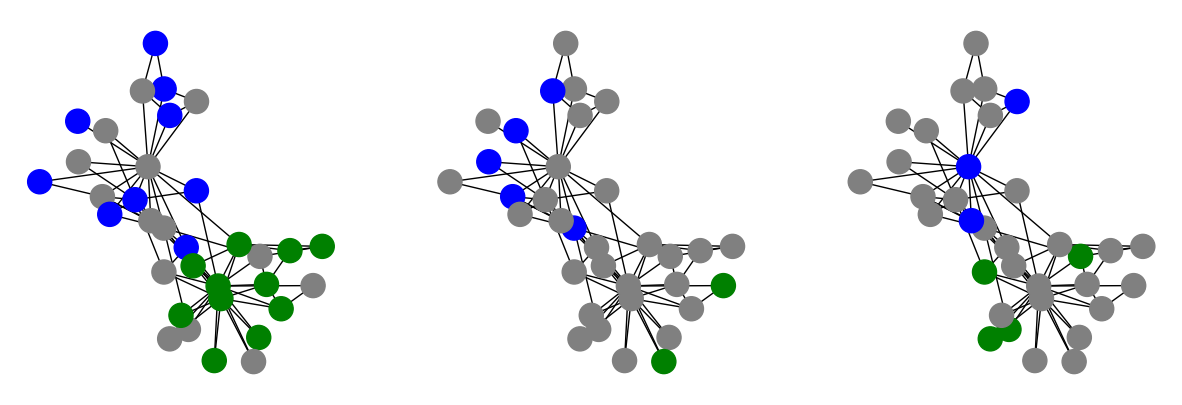

In [10]:
# Color the datasets

plt.figure(figsize=(15, 5))

for i, mask in enumerate([data.train_mask, data.val_mask, data.test_mask]):
    # Make a color map
    node_colors = ["grey"] * G.number_of_nodes()
    for node_idx, t in enumerate(mask):
        if t:
            node_colors[node_idx] = color_dict[node_idx]
    plt.subplot(1, 3, i + 1)
    nx.draw(G, pos=pos, node_color=node_colors)

In [11]:
# A bigger split

dataset = Planetoid(root=os.path.join("..", "data", "tmp", "Cora"), name="Cora")
data = dataset[0]


data = pyg_T.RandomNodeSplit(split="train_rest", num_val=0.2, num_test=0.2)(data)

In [12]:
print(sum(data.train_mask))
print(sum(data.val_mask))
print(sum(data.test_mask))

tensor(1624)
tensor(542)
tensor(542)


### Link prediction task

In [13]:
# ?GraphDataset

In [14]:
G = nx.karate_club_graph()
data = from_networkx(G)
print(data)

split = pyg_T.RandomLinkSplit(
    num_val=0.2, num_test=0.2, split_labels=False, is_undirected=False
)
data_train, data_val, data_test = split(data)

Data(edge_index=[2, 156], club=[34], weight=[156], name='Zachary's Karate Club', num_nodes=34)


In [15]:
data_val.edge_label_index

tensor([[ 5, 22, 32, 16,  4,  4,  0, 33, 33, 31, 32,  0,  0, 30,  0, 25, 33,  5,
         33, 27, 28,  1,  3,  0,  0,  8, 31, 20, 33, 19,  4,  3, 21,  4, 26, 24,
         20,  7, 17,  5, 13,  5, 26,  1, 11, 21, 24, 32,  9,  9,  8, 14,  2, 28,
          2, 18, 11, 10,  7, 23, 14, 16],
        [ 6, 32, 14,  5, 10,  0, 10, 29, 18, 28, 18,  6,  1,  8, 13, 24, 26, 10,
         32, 23,  2, 19,  1, 17, 12, 30, 32, 32, 15, 33,  6, 23, 18,  1, 14, 30,
          9, 15, 15, 26, 30, 23, 25, 31, 12, 27, 12, 26, 11, 17,  7, 30, 25, 27,
         33, 10, 19, 15, 26,  0, 10, 22]])

In [16]:
print(data_train)
print(data_val)
print(data_test)

Data(edge_index=[2, 94], club=[34], weight=[94], name='Zachary's Karate Club', num_nodes=34, edge_label=[188], edge_label_index=[2, 188])
Data(edge_index=[2, 94], club=[34], weight=[94], name='Zachary's Karate Club', num_nodes=34, edge_label=[62], edge_label_index=[2, 62])
Data(edge_index=[2, 125], club=[34], weight=[125], name='Zachary's Karate Club', num_nodes=34, edge_label=[62], edge_label_index=[2, 62])


In [17]:
def are_disjoint(edge_index_1, edge_index_2):
    """Checks if 2 edge indexes are disjoint"""
    edge_index_1_np = edge_index_1.T.detach().cpu().numpy()
    edge_index_2_np = edge_index_2.T.detach().cpu().numpy()

    set1 = set(tuple(edge) for edge in edge_index_1_np)
    set2 = set(tuple(edge) for edge in edge_index_2_np)
    return len(set1 & set2) == 0

In [18]:
num_edges = data.edge_index.shape[1]  # Does not include negative edges
# The next ones include negative edges
num_train_edges = data_train.edge_label_index.shape[1] // 2
num_val_edges = data_val.edge_label_index.shape[1] // 2
num_test_edges = data_test.edge_label_index.shape[1] // 2


print(f"Number of edges: {num_edges}")
print(f"Number of train edges: {num_train_edges}")
print(f"Number of val edges: {num_val_edges}")
print(f"Number of test edges: {num_test_edges}")
print()


train_pos_edge_index = data_train.edge_label_index[:, :num_train_edges]
train_neg_edge_index = data_train.edge_label_index[:, num_train_edges:]

val_pos_edge_index = data_val.edge_label_index[:, :num_val_edges]
val_neg_edge_index = data_val.edge_label_index[:, num_val_edges:]

test_pos_edge_index = data_test.edge_label_index[:, :num_test_edges]
test_neg_edge_index = data_test.edge_label_index[:, num_test_edges:]

print(are_disjoint(train_pos_edge_index, train_neg_edge_index))  # True
print(are_disjoint(train_pos_edge_index, val_pos_edge_index))  # True
print(are_disjoint(train_pos_edge_index, test_pos_edge_index))  # True
print(are_disjoint(train_neg_edge_index, test_neg_edge_index))  # True

Number of edges: 156
Number of train edges: 94
Number of val edges: 31
Number of test edges: 31

True
True
True
True


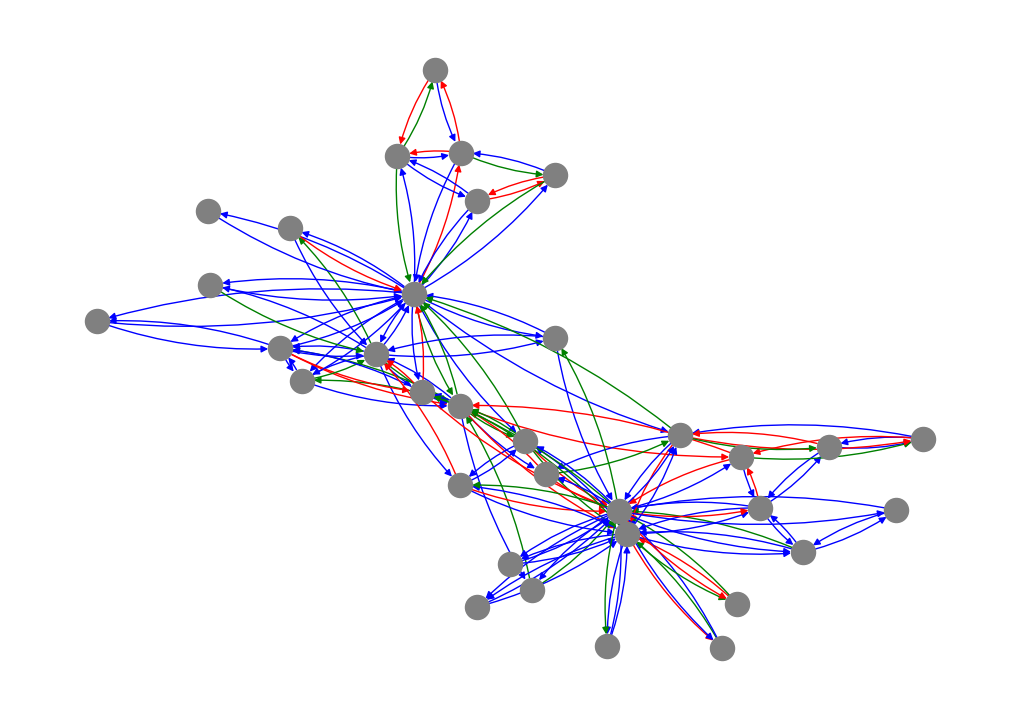

In [19]:
split = pyg_T.RandomLinkSplit(
    num_val=0.2, num_test=0.2, split_labels=False, is_undirected=False
)
data_train, data_val, data_test = split(data)

plt.figure(figsize=(10, 7))

edge_colors = {}
for current_dataset, color in zip(
    [data_train, data_val, data_test], ["blue", "green", "red"]
):
    # Iterate through edges and labels
    for edge, label in zip(
        current_dataset.edge_label_index.T, current_dataset.edge_label
    ):
        # Check if it's a positive edge
        if label != 0:
            # Add the color
            edge_colors[(edge[0].item(), edge[1].item())] = color


H = deepcopy(G)
H = nx.DiGraph(G)
nx.classes.function.set_edge_attributes(H, edge_colors, name="color")
colors = nx.get_edge_attributes(H, "color").values()

nx.draw(
    H,
    pos=pos,
    node_color="grey",
    edge_color=colors,
    width=1,
    connectionstyle="arc3,rad=0.1",
)